# Notebook 1

- If you work on Google Colab, [![open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/jouvetg/glamod/blob/main/01_notebook/glacier-modelling-1.ipynb) and you will donwload the repo in the first step below.

- If you work locally on your own PC, you can download the repo
```bash
git clone --depth 1 https://github.com/jouvetg/glamod.git
```
and then go the notebook folder, and work from there.

Let's now download the repo with the data if you are using Colab

In [1]:
import sys, os

if "google.colab" in sys.modules:
    print("Running in Colab: cloning repo...")
    !git clone --depth 1 https://github.com/jouvetg/glamod.git
else:
    print("Running locally: using local files.")

Running in Colab: cloning repo...
Cloning into 'glamod'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 69 (delta 4), reused 55 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 14.04 MiB | 25.99 MiB/s, done.
Resolving deltas: 100% (4/4), done.


Let's now go the working folder

In [2]:
if "google.colab" in sys.modules:
    %cd /content/glamod/01_notebook

/content/glamod/01_notebook


The goals of this notebook:
   - Get familiar with simplified SIA-based glacier model in 2D and 3D
   - Understand the implementation of underlying equations governing glacier evolution based on the SIA
   - Performing simple numerical experiments

Here we will play a simple glacier evolution model in 2D and 3D based on the simplified equations from the ice physics. Later on, we will use a more elaborated model (IGM) to mode the evolution of a real glacier with a "state-of-the-art" approach. We start with a "2D" and "idealized" glacier for simplicity.


# Glacier in 2D

<img src="https://svs.gsfc.nasa.gov/vis/a000000/a003800/a003849/antarctica_flows_1_00120_1024x576.jpg" alt="Map of Antarctica" width="40%">

*Ice flow field in Antarctica, the pink areas (ice shelves where the ice is floating) display the zone for the ice is the fastest. Check a the [NASA website](https://svs.gsfc.nasa.gov/3849/) for animations.*

## Ice Deformation

### Glen's flow law

Ice is often considered a non-Newtonian fluid, meaning that its flow behavior is not linear with respect to stress. This unique characteristic is primarily due to ice's crystalline structure and the way it deforms under stress. Glen's flow law provides a mathematical description of this behavior, quantifying how ice flow is related to stress. According to Glen’s law, the ice strain rate $ \dot{\epsilon} $ is proportional to the applied stress $ \tau $ raised to a power n=3, expressed as:


$$ \dot{\epsilon} = A \tau^n $$

Here, $ A $ is a temperature-dependent flow parameter, its unit is $Pa^{-3} \, y^{-1} $. Glen's exponent is very commonly taken as n=3. This non-linear relation illustrates that as stress increases, the rate of ice deformation also increases but at an accelerating rate, which is a fundamental concept in understanding ice dynamics.

Glen's flow law, together with the momentum conservation equations, yields a set of Stokes equations, which can be solved to derive the ice flow velocity of an ice body subject to gravitational deformation.

### Shallow Ice Approximation (SIA)

The Shallow Ice Approximation (SIA) is a simplification of the Stokes equation that applies to ice flow in regions where the ice thickness is much smaller than its horizontal extent. This approximation is particularly useful for modeling ice sheets and glaciers, as it assumes that the vertical shear stress is negligible compared to the gravitational forces acting on the ice. Consequently, the SIA focuses on the balance between the driving stress from the surface slope and the resisting stress due to the ice's weight and friction at the base. The velocity of ice flow under the SIA can be expressed as:

$$ u (z) = -\frac{A}{2} \left( \rho g \frac{\partial z}{\partial x} \right)^3 \left( h^4 - (h -z)^4 \right), \qquad (1) $$

where $ u $ is the ice velocity, $ h $ is the ice thickness, $ \rho $ is the ice density, $ g $ is the acceleration due to gravity, and $ \frac{\partial z}{\partial x} $ is the slope of the ice surface.

The following sketch of code implements the SIA formula (1) and allows us to visualize the ice velocity along the ice thickness as a function of depth $z$, ice thickness $h$, surface slope $\frac{\partial z}{\partial x}$, $A$ ice softness parameter. Run the code for different parameters of $A$, $h$, and slope $\frac{\partial z}{\partial x}$, and check at how the ice velocity profile change.

✅ **Yout turn !**

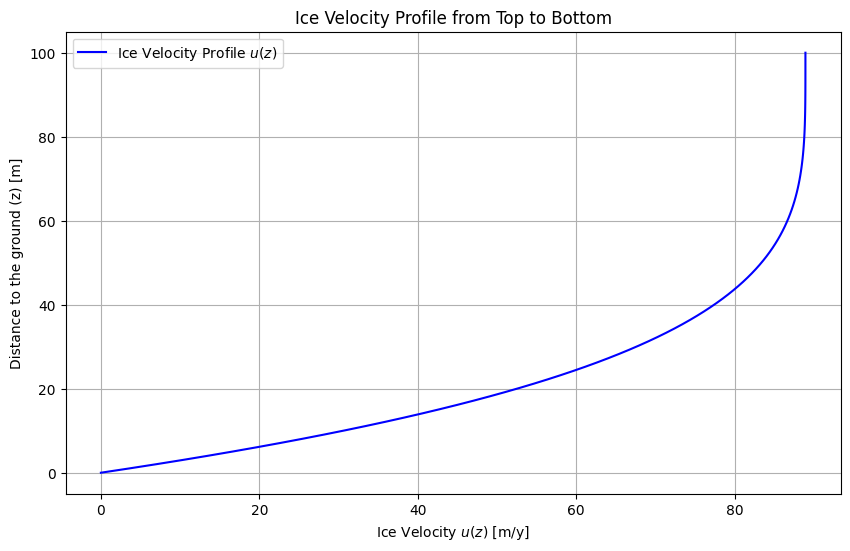

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# parameters
A = 2.5e-15  # Constant A, Arrhenius that determine the ice softness (Unit: $Pa^{-3} \, y^{-1} $)
rho = 910  # Density of ice in kg/m³
g = 9.81  # Acceleration due to gravity in m/s²
h = 100.0  # Total ice thickness in meters
dz_dx = -0.1  # Slope

z_values = np.linspace(0, h, 100)  # 100 points from 0 to h

# Calculate u(z) using the provided formula (1)
u_values = -0.5 * A * (rho * g * dz_dx)**3 * (h**4 - (h - z_values)**4)

# Plotting the profile (u(z) vs z)
plt.figure(figsize=(10, 6))
plt.plot(u_values, z_values, label='Ice Velocity Profile $u(z)$', color='blue')
plt.title('Ice Velocity Profile from Top to Bottom')
plt.xlabel('Ice Velocity $u(z)$ [m/y]')  # Adjust units based on context
plt.ylabel('Distance to the ground (z) [m]')
plt.grid()
plt.legend()
plt.show()


## Mass Conservation

The principle of mass conservation is fundamental in fluid dynamics and applies to the evolution of ice sheets as well. In the context of ice flow, mass conservation asserts that the rate of change of ice thickness over time is equal to the difference between the ice accumulation and ablation. Mathematically, this can be expressed as:

$$ \frac{\partial h}{\partial t} + \frac{\partial q}{\partial x} = SMB(z) \qquad (2) $$

where $ h $ is the ice thickness, $q= \int_b^s u dz$ is the ice flux, and $ SMB(z) $ is the Surface Mass Balance term representing accumulation minus ablation, $t$ is time, and $x$ is the distance along the model.

## Ice sheet evolution equation

When combining the Shallow Ice Approximation (1), which relates the flux $ q $ to the ice thickness and the slope of the ice surface, with the mass conservation equation (2), we obtain a nonlinear diffusive equation (given here in one dimension) that predicts the evolution of the geometry of an ice sheet, as follows:

$$ \frac{\partial h}{\partial t} =  \frac{\partial}{\partial x} \left( D(h) \frac{\partial z}{\partial x} \right) + SMB(z), \qquad (3) $$

where $h$ is the ice thickness, $D(h)$ is the dynamic diffusivity of the ice defined as

$$ D(h) = \frac{2 A}{5} (\rho g)^3 h^5 \left( \frac{\partial z}{\partial x} \right)^2. $$

## Numerical solving


Equation (3) must be solved numerically for doing the experiments proposed below.

For that purpose, the code below "discretizes" (3) using finite differences to approximate the time derivative, this yields to the following update rule:

$$ h^{n+1} = h^{n} + dt \left(  \frac{\partial}{\partial x} \left( D(h^n) \frac{\partial z^n}{\partial x} \right) + SMB^n(z) \right), $$

where we compute the ice thickness variable $h$ at time $t^0$, $t^1$, $t^2$, ..., $t^n$, ...

The same way, the domain of the glacier is discretized into small intervall, $x^0$, $x^1$, ..., $x^m$, ... and the ice thickness evolution is computed only at these points of the discretization.

## Climate

The snow accumulation budget (which turns into ice) at altitude and ice melt depends on precipitation and temperature. This mass balance $SMB(z)$ is commonly defined as a function of altitude (next figure to the right) and depends on three factors:

- 1) a slope that controls the mass balance gradient $b_\mathrm{grad}$,
- 2) a maximum value for accumulation $b_\mathrm{max}$,
- 3) the altitude of the equilibrium line $z_\mathrm{ELA}$ beyond which ice accumulates and below which ice melts.

Mathematically, $SMB(z)$ can thus be expressed as:

$$ SMB(z) = \min ( b_\mathrm{grad} (z-z_\mathrm{ELA}), b_\mathrm{max} ). \qquad (4) $$

The code in the next block gives an example of SMB function as function of $z$.

Text(0.5, 1.0, 'Example of SMB  as a function of elevation')

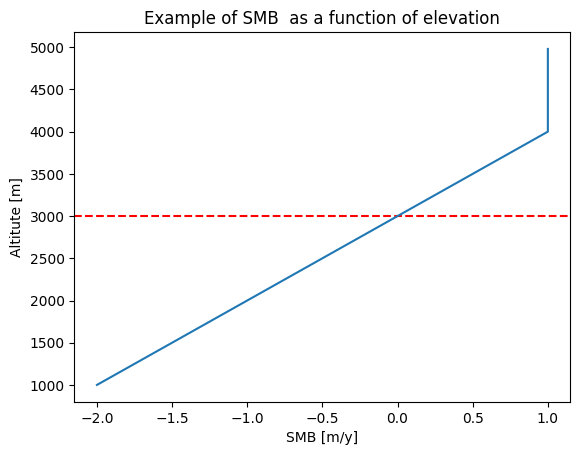

In [4]:
import numpy as np
import matplotlib.pyplot as plt

b_max=1
grad_b=0.001
z_ELA=3000

def smb_fct(elev):
    return np.minimum(grad_b * (elev - z_ELA), b_max)

elev = np.arange(1000, 5000, 20)
plt.axhline(y=z_ELA, color='r', linestyle='--', label='y = z_ELA')
plt.plot(smb_fct(elev), elev)
plt.ylabel('Altitute [m]')
plt.xlabel('SMB [m/y]')
plt.title('Example of SMB  as a function of elevation')


## Numerical Implementation

Here, we will solve numerically equation (3) with surface mass balance parametrization (4) in order to conduct simple numerical experiments of glacier evolution for different climate configurations. The model setup is as follows:

- We assume a glacier that forms along the axis $ x $ in one dimension.
- Use an initial ice thickness of 0 m.
- As boundary conditions, fix the ice thickness at both ends of the model to zero.
- Use the following logarithmic function to define the bedrock:
\begin{equation}
z_{bed}(x)  = 13522.8 - 1000 \times \log(x + 1000)
\end{equation}
- The additional parameters are given in the table below.

The code below permits to solve and visualize the temporal evolution of the results of the model.

| **Parameters**                             | **Values**                 |
|--------------------------------------------|-----------------------------|
| physical constant $ A $               | $ 2.5 \times 10^{-15} [Pa^{-3} yr^{-1}]$ |
| model length $ L $                      | 100 km                      |
| initial ice thickness                      | 0 m                         |
| maximum time step $ dt_{max} $         | 1 y                         |
| ice density $ \rho_{\mathrm{ice}} $    | 910 $kg/m^{3}$             |
| gravitational constant $ g $            | 9.81 m $s^{-2}$          |
| altitude of the equilibrium line $ z_{\mathrm{ELA}} $ | 1200 m       |
| maximum mass balance $ b_{\mathrm{max}} $ | 0.3 m/yr                 |
| mass balance gradient $ b_{\mathrm{grad}} $ | 0.001                  |
| total time                                | 3000 y                     |

*Parameters for the exercises.*

**Note:** It is important to check the units. Since
- $ Pa = Kg \, m^{-1} \,  s^{-2}$
- $[A] = Pa^{-3} \, y^{-1} $
- $[\rho g] = Kg \, m^{-3} \, m  \, s^{-2} = Kg \, m^{-2} \, s^{-2} = Pa \, m^{-1}$,

we have $[A(\rho g)^3 ] = Pa^{-3} \, y^{-1} \, Pa^3 \, m^{-3} = m^{-3} y^{-1} $  and therefore $[D] = m^2 y^{-1} $, which is consistent.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def model_glacier_1d(smb_fct,A,ttot):

    Lx = 1.4e5  # model length, m

    rhog = 910 * 9.81  # ice density kg/m^3 * gravity m/s^{-2}
    kD = (2.0/5.0) * A  * rhog**3  # lump all constants for diffusivity together

    # Numerics
    nx = 201  # number of cells
    dx = Lx / (nx - 1)  # number of cells
    dtmax = 1      # initial dt, will be changed within loop, yr
    dt    = dtmax  # initial dt, will be changed within loop, yr
    x = np.linspace(0, Lx, nx)  # x-coordinates
    nout = 500  # frequency of plotting

    # Initialization
    Z_bed = - 1000 * np.log(x + 1000)  + 13522.8 # topography
    H = np.zeros(nx)  # ice thickness
    time = 0.0  # initialize time
    nplot = 0  # counter for plotting

    Z = Z_bed + H  # ice surface

    time=0
    it=0

    fig, ((ax1,ax2)) = plt.subplots(1,2,figsize=(12,5))

    eps=[]

    # Time loop
    while time < ttot:

        # compute dHdt due to diffusion
        H_av = 0.5 * (H[:-1] + H[1:])            # average height between cells (nx-1)
        D = kD * H_av**5 * (np.diff(Z) / dx)**2  # diffusivity (nx-1)
        qx = -D * np.diff(Z) / dx                # ice flux
        dHdt = -np.diff(qx) / dx                 # change in ice thickness from flow

        # update time step as function of D
        dt = min(dtmax, dx**2 / (2.1 * np.max(D)))  # update time step

        # update thickness of ice (iceflow)
        H[1:-1] += dt * dHdt

        # update ice thickness (mass balance)
        smb, z_ELA = smb_fct(Z,time)
        H[1:-1] += dt * smb[1:-1]

        H[H < 0] = 0  # set any negative thickness to 0

        H[0] = 0  # boundary conditions
        H[-1] = 0  # boundary conditions

        Z = Z_bed + H  # update ice surface
        time += dt  # update time

        it += 1

        # Visualization
        if it % nout == 0:

            clear_output(wait=True)  # Clear the output in VS Code
            ax1.cla()
            ax2.cla()

            ax1.plot(x / 1000, Z, 'b', linewidth=2)
            ax1.plot(x / 1000, Z_bed, 'k', linewidth=1)
            ax1.plot([x[0], x[-1] / 1000], [z_ELA, z_ELA], 'g')
            ax1.set_ylim([np.min(Z_bed), np.max(Z_bed)])
            ax1.set_ylabel('Elevation, m')
            ax1.set_xlabel('Distance, km')
            ax1.set_title('Glacier apres '+str(int(time)) + ' années')

            # ax2.subplot(2, 2, 3,aspect=20.0)
            ax2.plot(x / 1000, smb, 'b', linewidth=2)
            ax2.plot([x[0], x[-1] / 1000], [0, 0], 'k', linewidth=1)
            ax2.set_title('Bilan de masse effectif')
            ax2.set_xlabel('Distance, km')
            ax2.set_ylabel('Bilan de masse, m/a')

            display(fig)


Let's now run the model for different configurations of SMB function and ice flow parameter ($A$) and explore their influence on the result.
Take the following code, and play with it to answer the following questions:
   - How long does it take to reach a steady state (roughly) ?
   - change the equilibrium line altitude (ELA) from 3000 to 4000, what do you observe?
   - change the surface mass balance gradient grad_b (multiply and divide by 3), what do you observe?
   - change the ice flow parameter, taking one order of magnitude less (harder ice), and one more (softer), what do you observe?

✅ **Your turn !**

KeyboardInterrupt: 

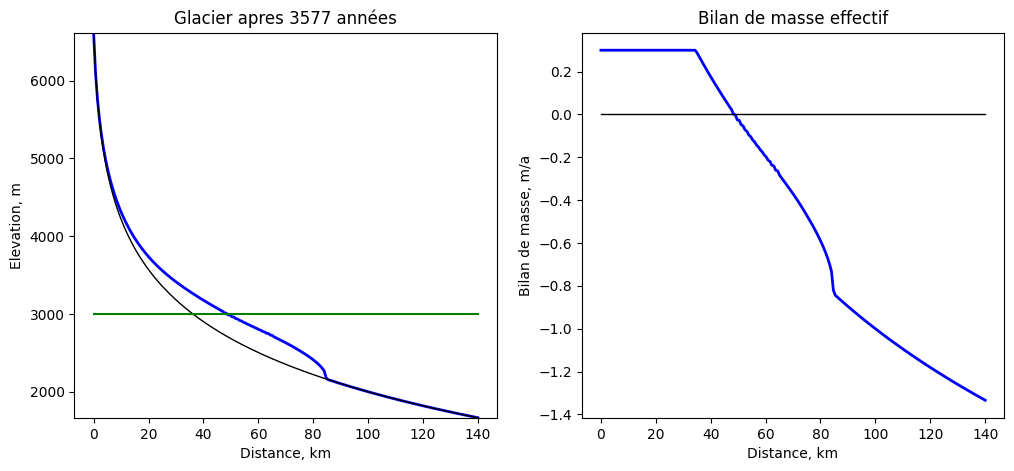

In [6]:
import numpy as np

b_max=0.3
grad_b=0.001
z_ELA=3000
A=2.5e-15
ttot=5000

def smb_fct(Z,time):
    return np.minimum(grad_b * (Z - z_ELA), b_max) , z_ELA

model_glacier_1d(smb_fct,A,ttot)


In the next exercise, we will make the ELA vary with time, following a cosine curve to mimic a series of cooling and warming events as follows:

Text(0.5, 1.0, 'Example of ELA as a function of time with a frequency of 2000 years')

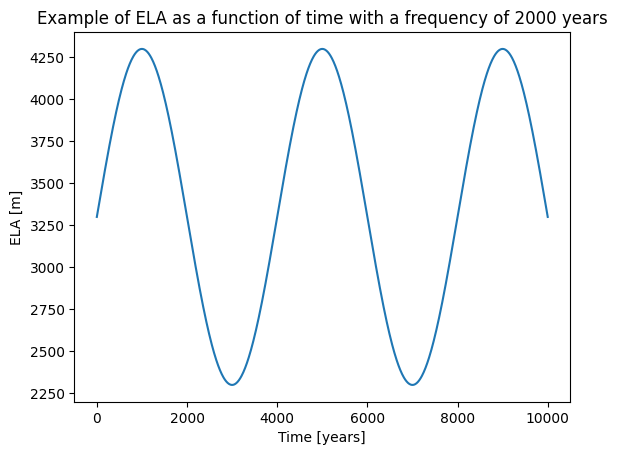

In [7]:
time = np.arange(0, 10001, 10)
plt.plot(time, 3300 + 1000 * np.sin(time * np.pi / 2000))
plt.xlabel('Time [years]')
plt.ylabel('ELA [m]')
plt.title('Example of ELA as a function of time with a frequency of 2000 years')

Observe the time lapse between the minimum (resp. maximum) in ELA, and the time the glacier reach its maximum (resp. minimum). This is due to the fact that glacier have a certain inertia as system. Try increasing or decreasing the frequency of these climate warming and cooling cycles.
✅ **Your turn !**

KeyboardInterrupt: 

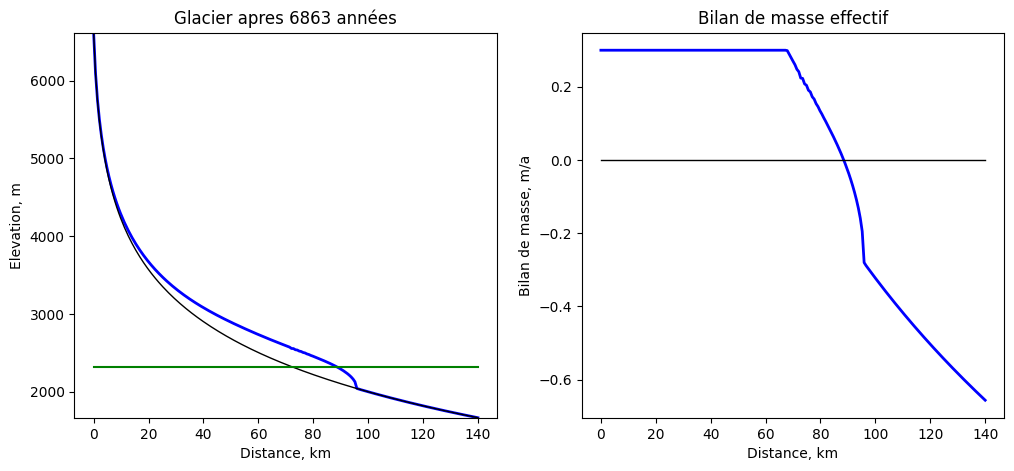

In [8]:
import numpy as np

b_max=0.3
grad_b=0.001
A=2.5e-14
freq=2000
ttot = 20000

def ela_fct(time):
    return 3300 + 1000 * np.sin(time * np.pi / freq)

def smb_fct(Z,time):
    return np.minimum(grad_b * (Z - ela_fct(time)), b_max), ela_fct(time)

model_glacier_1d(smb_fct,A,ttot)

# Glacier in 3D

We will now consider a more complex situation involving a three-dimensional glacier, namely Gorner Glacier located near Zermatt.

<img src="https://images.contenthub.dev/xshiytapvw9a/e404ac0c4deb0f9ef3d3bd6859603bb2/Gornergletscher%20Wanderung%20Rotenboden.jpg?fm=avif&fit=fill&q=45&h=640&w=1140"  width="50%">

*Gorner Glacier*

The objective of this exercise is to implement the ice equation to simulate a glacial landscape. In 3D, the evolution of ice thickness is represented by

\begin{equation}
\frac{\partial h}{\partial t} - \frac{\partial}{\partial x} \left( D(h,z) \frac{\partial z}{\partial x} \right) - \frac{\partial}{\partial y} \left( D(h,z) \frac{\partial z}{\partial y} \right) =  SMB(z), \quad (1)
\end{equation}

where $ h $ is the ice thickness, $ t $ is time, $ b $ is the mass balance (accumulation minus surface ablation), $ D $ is the dynamic diffusivity of the ice, and $ z $ is the altitude of the ice surface. The non-linearity arises from the diffusivity constant $ D $, which itself depends on the local ice thickness $ h $ and the slope of the ice surface:

\begin{equation}
D(h,z) = \frac{2 A}{5} (\rho g)^3 h^5 ||\nabla S||^2 \qquad (2)
\end{equation}

where $ ||\nabla S|| $ is the norm of the local slope of the ice surface. At first glance, the problem is very similar to the 1D case, but the exact positioning of all values on the model grid is more complex in 2D.

The following code implements the model with the following setup:

- Use an initial ice thickness of 0 m, and maintain a thickness of 0 at the edges of the model (boundary conditions).
- The bedrock topography is given in the file `topg.txt`
- The rest of the parameters are given in the table below.

| **Parameters:**                                   | **Values:**                  |
|--------------------------------------------------|-------------------------------|
| initial ice thickness                             | 0 m                           |
| ice density $ \rho_\mathrm{ice} $                | 910 kg/m$^3$                 |
| physical constant $ A $                           | $ 2.5 \times 10^{-18} Pa^{-3} yr^{-1} $ |
| maximum mass balance $ b_\mathrm{max} $          | 0.3 m/yr                     |
| mass balance gradient $ b_\mathrm{grad} $        | 0.001                          |
| total time                                       | 5000 y                        |

✅ **Your turn !**

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import display, clear_output

def model_glacier_2d(smb_fct):

    # Physical parameters
    ttot = 5000   # Time limit (yr)
    rho = 910.0   # Ice density (g/m^3)
    g   = 9.81    # Earth's gravity (m/s^2)
    A   = 2.5e-18   # Deformation constant (Pa^-3 y^-1)
    xz = 6327   # x-coordinate of Zermatt
    yz = 14672  # y-coordinate of Zermatt

    # load the topography of Gorner Glacier
    Z_topo = np.loadtxt('topg.txt')[::2,::2]
    ny,nx = Z_topo.shape

    dx=200
    dy=200

    Lx = dx*nx
    Ly = dy*ny

    nout = 1000  # Frequency of plotting
    dtmax = 1   # maximum time step
    dt = dtmax  # Initial time step

    x = np.linspace(0, Lx, nx)  # x-coordinates
    y = np.linspace(0, Ly, ny)  # y-coordinates

    H_ice = np.zeros((ny, nx))  # Initial ice thickness
    Z_surf = Z_topo + H_ice  # Initial ice surface
    time = 0  # Initial time
    it = 0

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 6),dpi=100)

    s = ax1.imshow(Z_surf, extent=[0, Lx/1000, 0, Ly/1000],  cmap='terrain', origin='lower', vmin=0, vmax=4800)
    cbar = fig.colorbar(s, ax=ax1, orientation='horizontal', label='Elevation (m)')

    ss = ax2.imshow(np.where(H_ice>0,H_ice,np.nan), extent=[0, Lx/1000, 0, Ly/1000], cmap='jet', origin='lower', vmin=0, vmax=1000)
    ccbar = fig.colorbar(ss, ax=ax2, orientation='horizontal', label='Ice Thickness (m)')

    # Loop
    while time < ttot:

        # Update time
        time += dt
        it   += 1

        # Calculate H_avg, size (ny-1,nx-1)
        H_avg = 0.25 * (H_ice[:-1, :-1] + H_ice[1:, 1:] + H_ice[:-1, 1:] + H_ice[1:, :-1])

        # Compute Snorm, size (ny-1,nx-1)
        Sx = np.diff(Z_surf, axis=1) / dx
        Sy = np.diff(Z_surf, axis=0) / dy
        Sx = 0.5 * (Sx[:-1, :] + Sx[1:, :])
        Sy = 0.5 * (Sy[:, :-1] + Sy[:, 1:])
        Snorm = np.sqrt(Sx**2 + Sy**2)

        # Compute D, size (ny-1,nx-1)
        D = (2.0/5.0) * A * (rho * g)**3.0 * H_avg**5 * Snorm**2

        # Compute dt
        dt = min(min(dx, dy)**2 / (4.1 * np.max(D)), dtmax)

        # Compute qx, size (ny-2,nx-1)
        qx = -(0.5 * (D[:-1,:] + D[1:,:])) * np.diff(Z_surf[1:-1,:], axis=1) / dx

        # Compute qy, size (ny-1,nx-2)
        qy = -(0.5 * (D[:,:-1] + D[:,1:])) * np.diff(Z_surf[:,1:-1,], axis=0) / dy

        # Update rule (diffusion)
        dHdt = -(np.diff(qx, axis=1) / dx + np.diff(qy, axis=0) / dy)
        H_ice[1:-1, 1:-1] += dt * dHdt # size (ny-2,nx-2)

        smb = smb_fct(Z_surf)

        # Update rule (mass balance)
        H_ice[1:-1, 1:-1] += dt * smb[1:-1, 1:-1]

        # Update rule (positive thickness)
        H_ice = np.maximum(H_ice, 0)

        # updatesurface topography
        Z_surf = Z_topo + H_ice

        # Display
        if it % nout == 0:

            clear_output(wait=True)  # Clear the output in VS Code
            ax1.cla()
            ax2.cla()

            ax1.imshow(Z_surf, extent=[0, Lx/1000, 0, Ly/1000],  cmap='terrain',origin='lower')
            ax1.plot(xz/1000, yz/1000, 'k', marker='o', markersize=10)
            ax1.set_title('Ice Surface at ' + str(int(time))+ ' y')
            ax1.set_xlabel('Distance, km')
            ax1.set_ylabel('Distance, km')
            ax1.axis('equal')

            ax2.imshow(np.where(H_ice>0,H_ice,np.nan), extent=[0, Lx/1000, 0, Ly/1000], cmap='jet',origin='lower')
            ax2.plot(xz/1000, yz/1000, 'k', marker='o', markersize=10)
            ax2.set_title('Ice Thickness at ' + str(int(time))+ ' y')
            ax2.set_xlabel('Distance, km')
            ax2.set_ylabel('Distance, km')
            ax2.axis('equal')
            display(fig)


Currently, the ELA of alpine glaciers is around 3000 m. Run the model until the glacier is approximately in equilibrium (5000 years), and compare your results to the Gorner Glacier with the images on [map.geo.admin.ch](https://map.geo.admin.ch). Try to find the ELA that produces a glacier (in equilibrium) that best fits the current state of the Gorner Glacier. To help you, the city of Zermatt is indicated with a black dot.


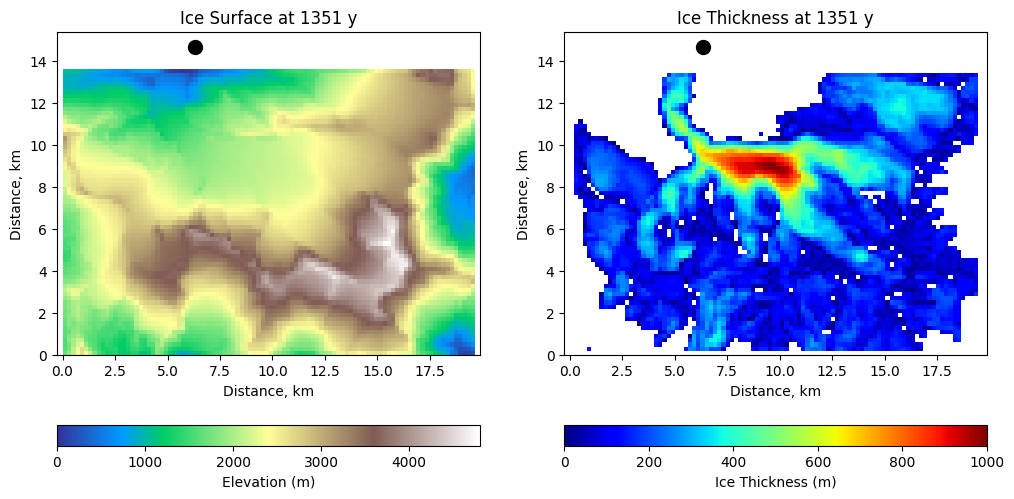

KeyboardInterrupt: 

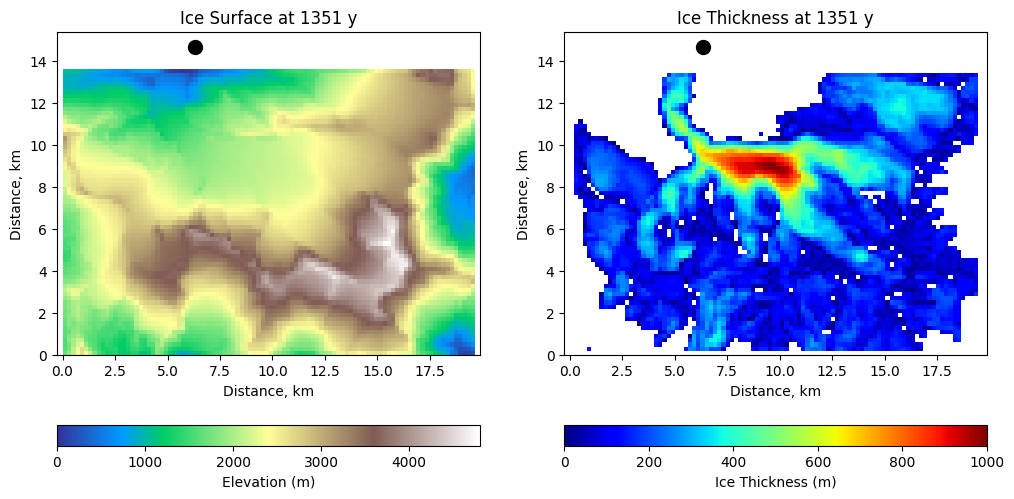

In [10]:
import numpy as np

b_max=0.3
grad_b=0.002
z_ELA=3100

def smb_fct(Z):
    return np.minimum(grad_b * (Z - z_ELA), b_max)

model_glacier_2d(smb_fct)